In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
y_train = df_train.loc[:, 'Survived']
all_data = pd.concat([df_train.drop(columns='Survived'), df_test])

In [4]:
import re
def n_s(text):
    a = text.split()
    if len(a) > 1:
        a[0] = re.sub(r'[^a-zA-Z]','',a[0])
        return a[0]
    else:
        return 'X'
all_data['Ticket'] = all_data['Ticket'].apply(n_s)
all_data['Male'] = (all_data['Sex'] == 'male')*1.0
all_data = all_data.drop(columns='Sex')
all_data = all_data.drop(columns='Name')
from sklearn.linear_model import Lasso
def predict_numerical_nan_values(data, feature, id_col):
    train = data[data[feature].notna()]
    test = data[data[feature].isna()].drop(columns=[feature, id_col])
    y = train[feature]
    notna_cols = (data.drop(columns=[feature, id_col]).isna().sum()== 0).values
    num_data = pd.get_dummies(data.iloc[:, notna_cols])
   
    X = num_data[num_data[feature].notna()].drop(columns=[feature, id_col])
    
    test = num_data[num_data[feature].isna()].drop(columns=[feature, id_col])
    model = Lasso().fit(X, y)
    preds = model.predict(test)
    data.loc[data[feature].isna(),feature] = preds
predict_numerical_nan_values(all_data, 'Age', 'PassengerId')

In [5]:

all_data['Embarked'] = all_data['Embarked'].fillna('S')
all_data['Fare'] = all_data['Fare'].fillna(all_data['Fare'].mean())
all_data = all_data.drop(columns='PassengerId')
#all_data = all_data.drop(columns='Cabin')
all_data['Age'] = (all_data['Age'] - all_data['Age'].min())/ (all_data['Age'].max() - all_data['Age'].min())
all_data['Fare'] = (all_data['Fare'] - all_data['Fare'].min())/ (all_data['Fare'].max() - all_data['Fare'].min())
all_data = pd.get_dummies(all_data)

In [6]:
X_train = all_data.iloc[:df_train.shape[0],:]
X_test = all_data.iloc[df_train.shape[0]:, :]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f21c8970fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f21c89866d8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f21c8970c18>,
 'medians': [<matplotlib.lines.Line2D at 0x7f21c8986d68>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f21c89160f0>,
 'means': []}

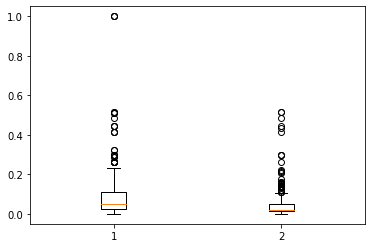

In [7]:
plt.boxplot([X_train.loc[y_train== 1,'Fare'],X_train.loc[y_train== 0,'Fare']] )

In [8]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [9]:
svm_clf = SVC(gamma='scale')
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3)
knn_clf = KNeighborsClassifier(n_neighbors=3)
lr_clf = LogisticRegression(solver='lbfgs', multi_class='multinomial',random_state=1)
rf_clf = RandomForestClassifier(n_estimators=50, random_state=1)
gnb_clf = GaussianNB()
svm_clf.fit(X_train, y_train)
sgd_clf.fit(X_train, y_train)
knn_clf.fit(X_train, y_train)
lr_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
gnb_clf.fit(X_train, y_train)
print(svm_clf.score(X_train, y_train))
print(sgd_clf.score(X_train, y_train))
print(knn_clf.score(X_train, y_train))
print(lr_clf.score(X_train, y_train))
print(rf_clf.score(X_train, y_train))
print(gnb_clf.score(X_train, y_train))

/home/matheus/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.7968574635241302
0.8260381593714927
0.8866442199775533
0.8574635241301908
0.9910213243546577
0.7508417508417509


In [10]:

eclf1 = VotingClassifier(estimators=[('svm', svm_clf), ('sgd', sgd_clf), ('knn', knn_clf), ('rf', rf_clf), ('gnb', gnb_clf)], voting='hard', weights=[0.5,1,1,1.5,0.5])
eclf1.fit(X_train, y_train)

VotingClassifier(estimators=[('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)), ('sgd', SGDClassifier(alpha=0.0001, average=False, c...andom_state=1, verbose=0, warm_start=False)), ('gnb', GaussianNB(priors=None, var_smoothing=1e-09))],
         flatten_transform=None, n_jobs=None, voting='hard',
         weights=[0.5, 1, 1, 1, 0.5])

In [11]:
eclf1.score(X_train, y_train)

0.8956228956228957

In [12]:
y_pred = eclf1.predict(X_test)

In [13]:
df_test['Survived'] = y_pred
preds = df_test.loc[:, ['PassengerId','Survived']]

In [14]:
preds.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [15]:
preds.to_csv('preds.csv', index=False)

In [16]:
pd.read_csv('preds.csv')

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
